In [1]:
## Relevant modules.
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations 

In [2]:
## Reading file.
file = 'data/data_panel.csv'
panel = pd.read_csv(file, header=0)
print(panel.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8294 entries, 0 to 8293
Data columns (total 12 columns):
doc_code       8294 non-null int64
spec_code      8294 non-null int64
spec_es        8294 non-null object
spec_en        8294 non-null object
year           8294 non-null int64
n_visits       8294 non-null int64
n_surgeries    8294 non-null int64
n_patients     8294 non-null int64
c_visit        8288 non-null float64
c_surgery      8292 non-null float64
dep_code       8294 non-null int64
department     8294 non-null object
dtypes: float64(2), int64(7), object(3)
memory usage: 777.6+ KB
None


I want to know how specialty, department and year affects number of visits and surgeries.  
I am not using number of patients because it is very similar to number of visits.  
Number of patients and visits are not the same but are highly correlated (as seen in 05_first_analyses).  
I want to make sure I have more than 30 observations for each specialty in each department in each year.  
The group below with 4 specialties, 2 departments and 5 years obeys that condition.  
There are more than 30 observations (doctors) for each specialty in each department in each year.

In [3]:
group_1 = panel.groupby(['spec_code','dep_code','year'])[['doc_code']].count()
group_1.rename(columns={'doc_code': 'doc_count'}, inplace=True)
group_1 = group_1[group_1['doc_count'] > 30].reset_index()

group_2 = group_1.groupby(['spec_code','dep_code'])[['year']].count()
group_2.rename(columns={'year': 'year_count'}, inplace=True)
group_2 = group_2[group_2['year_count'] == 5].reset_index()

group_3 = group_2.groupby(['spec_code'])[['dep_code']].count()
group_3.rename(columns={'dep_code': 'dep_count'}, inplace=True)
group_3 = group_3[group_3['dep_count'] > 1].reset_index()

merge_3_2 = pd.merge(group_3, group_2, on=['spec_code'])
merge_3_2_1 = pd.merge(merge_3_2, group_1, on=['spec_code','dep_code'])

group = merge_3_2_1.drop(['year_count','dep_count'], axis=1)
print(group.set_index(['spec_code','dep_code','year']))
print('Total doc observations:', group['doc_count'].sum())

                         doc_count
spec_code dep_code year           
200       5        2008         74
                   2009         69
                   2010         69
                   2011         72
                   2012         64
          76       2008         34
                   2009         38
                   2010         38
                   2011         39
                   2012         42
341       5        2008        100
                   2009         98
                   2010        101
                   2011         95
                   2012         94
          76       2008         52
                   2009         44
                   2010         47
                   2011         50
                   2012         51
480       5        2008        118
                   2009        115
                   2010        109
                   2011        115
                   2012        104
          76       2008         35
                   2

The subpanel below comes from the original panel (original data opened in the beginning of this jupyter file) but takes into account only the 4 specialties, 2 departments and 5 years seen above. Thus, instead of 8294 entries, we have 2552 entries. In addition, I have created the variable surgeries2visits to represent the ratio between number of surgeries and number of visits. I have also created dummy variables for each specialty and department.

In [4]:
subpanel = pd.merge(panel, group, on=['spec_code','dep_code','year'])
subpanel.drop('doc_count', axis=1, inplace=True)
subpanel['surgeries2visits']=subpanel['n_surgeries']/subpanel['n_visits']

dummies = pd.get_dummies(subpanel[['spec_en','department']])
dummies_old_names = list(dummies.columns.values)
dummies_new_names = []

for i in dummies_old_names:
    if i[0:4] == 'spec':
        dummies_new_names.append(i[0:4]+i[7:11])
    elif i[0:4] == 'depa':
        dummies_new_names.append(i[0:3]+i[10:14])

dummies_dic_names = dict(zip(dummies_old_names, dummies_new_names))
dummies.rename(columns=dummies_dic_names,inplace=True)

subpanel = pd.concat([subpanel,dummies],axis=1)
print(subpanel.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2552 entries, 0 to 2551
Data columns (total 19 columns):
doc_code            2552 non-null int64
spec_code           2552 non-null int64
spec_es             2552 non-null object
spec_en             2552 non-null object
year                2552 non-null int64
n_visits            2552 non-null int64
n_surgeries         2552 non-null int64
n_patients          2552 non-null int64
c_visit             2552 non-null float64
c_surgery           2552 non-null float64
dep_code            2552 non-null int64
department          2552 non-null object
surgeries2visits    2552 non-null float64
spec_der            2552 non-null uint8
spec_gyn            2552 non-null uint8
spec_oph            2552 non-null uint8
spec_oto            2552 non-null uint8
dep_ant             2552 non-null uint8
dep_val             2552 non-null uint8
dtypes: float64(3), int64(7), object(3), uint8(6)
memory usage: 294.1+ KB
None


Here I start to analyse how specialty, department and year may affect number of surgeries, number of visits and surgeries-to-visits ratio. The horizontal width of each "violin" figure shows how the data is scattered (i.e., roughly speaking, the size of the uncertainty) whereas the vertical height informs the data density in each point. Specialty seems to be main factor affecting surgeries, visits and surgeries-to-visits ratio.

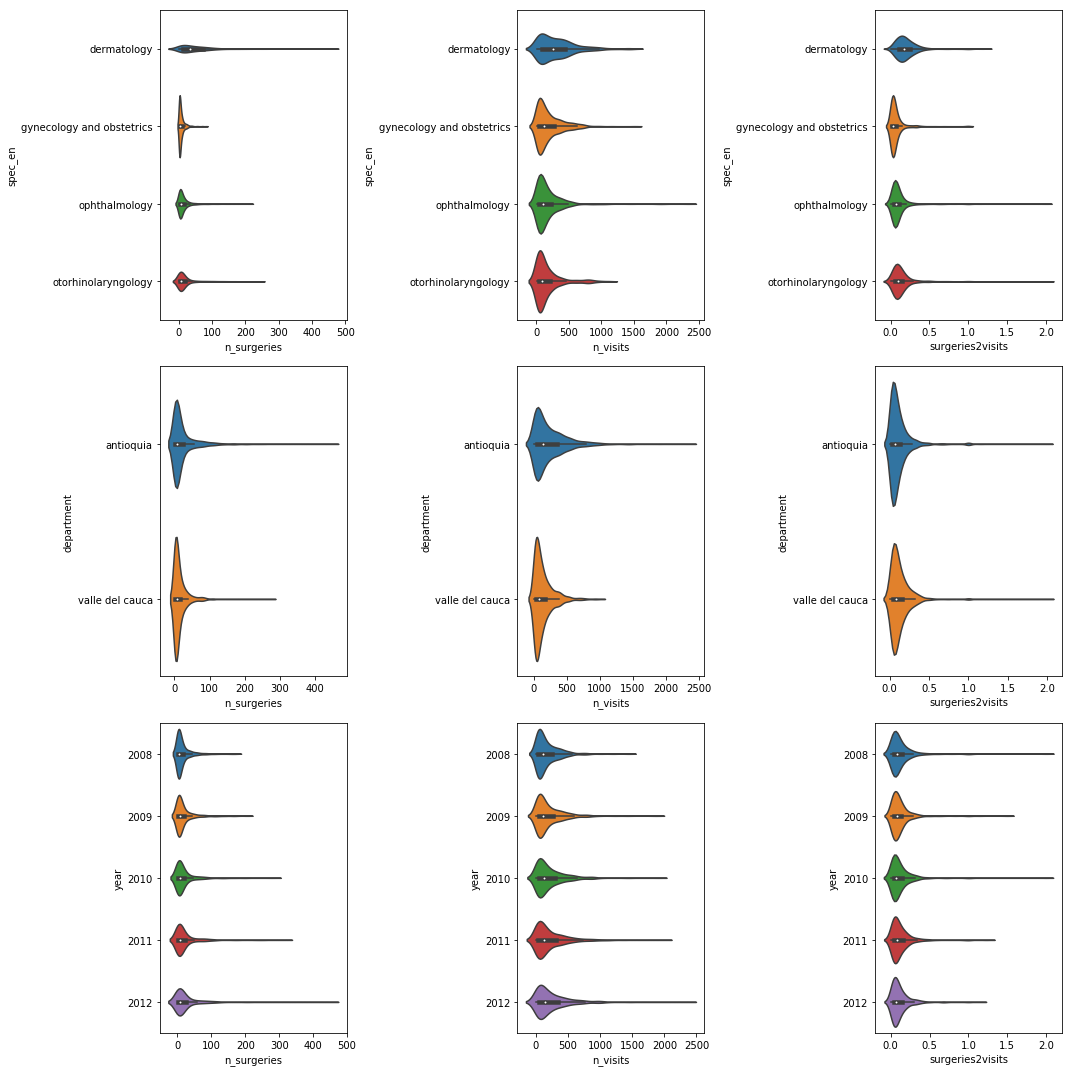

In [5]:
fig, ax = plt.subplots(3, 3, figsize=(15,15))
for i in [['spec_en',0],['department',1],['year',2]]:
    _ = sns.catplot(x='n_surgeries', y=i[0], data=subpanel, 
                    orient='h', kind='violin', ax=ax[i[1],0])
    plt.close()
    _ = sns.catplot(x='n_visits', y=i[0], data=subpanel, 
                    orient='h', kind='violin', ax=ax[i[1],1])
    plt.close()
    _ = sns.catplot(x='surgeries2visits', y=i[0], data=subpanel,
                    orient='h', kind='violin', ax=ax[i[1], 2])
    plt.close()
plt.tight_layout()
plt.show()

Next I present heatmaps illustrating correlations between variables. The numbers are linear correlation coefficients that goes from 1 (perfect positive linear correlation) to -1 (perfect negative linear correlation). As expected, there seems to be a positive linear correlation between visits and surgeries. 

The first heatmap uses the codes for specialty and department. This is not good because the codes provide an arbitrary scale (why one specialty has a code number higher than other?). That arbitrary scale may affect the correlation with other variables, so we don't know if we are seeing the true correlations or some random correlations due to the arbitrary scale. The main problem is specialty because it has 4 different possibilities (department only has 2 possibilities, so the use of an arbitrary scale is not so problematic and can be easily substituted for 0 and 1).

The second heatmap introduces the cost of surgery (c_surgery) and the cost of visit (c_visit). Unfortunately, those variables are not disaggregated: they are average costs for each specialty in each year. That's why I haven't used them much. However, because they are related to specialty, they could provide an alternative non-arbitrary scale for specialty. Not surprisingly, c-surgery and c-visit show correlations with spec_code and year (remember: they are average costs for each specialty in each year). Despite not being disaggregated, those variables show interesting correlations with number of surgery and number of visits.

The third heatmap introduces dummy variables for each specialty and department. Here we can see even better the expected correlation between them and c-surgery or c-visit. The use of dummies for specialty and department plus the inclusion of c-surgery and c-visit is an interesting approach, although we may run into a multicolinearity issue. Of course, we need to be carefull not to introduce all dummies in a regression to avoid perfect correlation among them (as seen between the dummies for departments in the heatmap) and stress the aggregated nature of c_surgery and c_visit. I would also use dummies for years so "year" = 0 has meaning. 

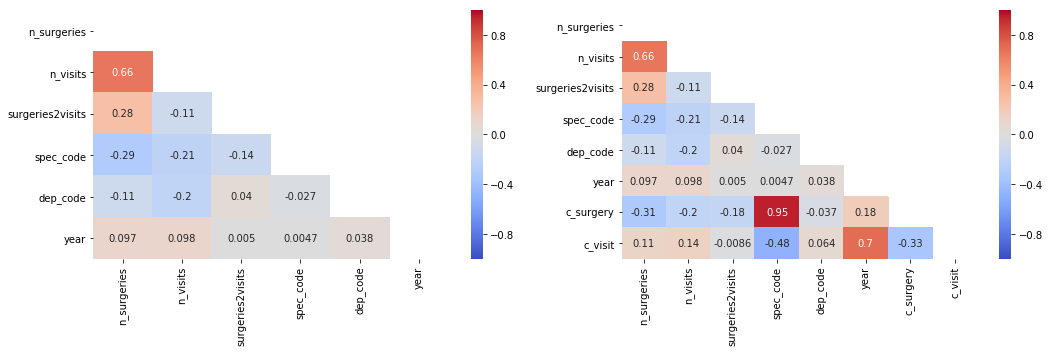

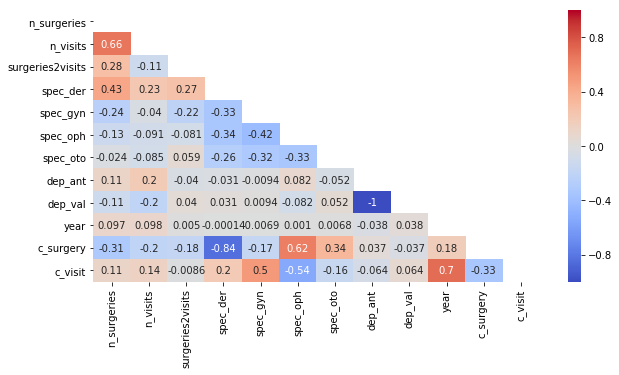

In [6]:
subset_1 = subpanel[['n_surgeries','n_visits','surgeries2visits',
                     'spec_code','dep_code','year']]
subset_1_corr = subset_1.corr()
mask_1 = np.zeros_like(subset_1_corr, dtype=np.bool)
mask_1[np.triu_indices_from(mask_1)] = True

subset_2 = subpanel[['n_surgeries','n_visits','surgeries2visits',
                     'spec_code','dep_code','year','c_surgery','c_visit']]
subset_2_corr = subset_2.corr()
mask_2 = np.zeros_like(subset_2_corr, dtype=np.bool)
mask_2[np.triu_indices_from(mask_2)] = True

subset_3 = subpanel[['n_surgeries','n_visits','surgeries2visits',
                     'spec_der','spec_gyn','spec_oph','spec_oto',
                     'dep_ant','dep_val','year','c_surgery','c_visit']]
subset_3_corr = subset_3.corr()
mask_3 = np.zeros_like(subset_3_corr, dtype=np.bool)
mask_3[np.triu_indices_from(mask_3)] = True

fig, ax = plt.subplots(1, 2, figsize=(15,5))
_ = sns.heatmap(subset_1_corr, vmin=-1, cmap='coolwarm',
                annot=True, mask = mask_1, ax=ax[0])

_ = sns.heatmap(subset_2_corr, vmin=-1, cmap='coolwarm',
                annot=True, mask = mask_2, ax=ax[1])
plt.tight_layout()

plt.figure(figsize=(10,5))
_ = sns.heatmap(subset_3_corr, vmin=-1, cmap='coolwarm',
                annot=True, mask = mask_3)
plt.show()

From here, I will start to make a series of bootstrap statistical tests to see how specialty, department and year may be affecting number of surgeries, number of visits and surgeries-to-visits ratio. First I will test:

H0: difference in means for surgeries/visits/surgeries-to-visits ratio in different categories is by chance (they actually come from the same distribution).

In [7]:
def diff_of_means(data_1, data_2):
    diff = np.mean(data_1) - np.mean(data_2)
    return diff

def permutation_sample(data_1, data_2):
    data = np.concatenate((data_1, data_2))
    permuted_data = np.random.permutation(data)
    perm_sample_1 = permuted_data[:len(data_1)]
    perm_sample_2 = permuted_data[len(data_1):]
    return perm_sample_1, perm_sample_2

def draw_perm_reps(data_1, data_2, func, size=1):
    perm_replicates = np.empty(size)
    for i in range(size):
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)
    return perm_replicates

In [8]:
np.random.seed(10)
print('H0: difference in means for surgeries in different categories \
is by chance (they actually come from the same distribution).')

categories = ['spec_en','department','year']
for i in categories:
    print('\nCategory:',i)
    names = np.unique(subpanel[i])
    comb = list(combinations(names, 2))
    for j in comb:
        data_1 = subpanel['n_surgeries'][subpanel[i]==j[0]]
        data_2 = subpanel['n_surgeries'][subpanel[i]==j[1]]
        empirical_diff_means = diff_of_means(data_1, data_2)
        perm_replicates = draw_perm_reps(data_1, data_2, diff_of_means, size=1000)
        if empirical_diff_means >= 0:
            p = np.sum(perm_replicates >= empirical_diff_means)/len(perm_replicates)
        else:
            p = np.sum(perm_replicates <= empirical_diff_means)/len(perm_replicates)
        print('p-value for H0 in the case of',j[0],'vs.',j[1],'is',p)
        if p > 0.025:
            print('H0 is not rejected.')
        else:
            print('H0 is rejected.')

H0: difference in means for surgeries in different categories is by chance (they actually come from the same distribution).

Category: spec_en
p-value for H0 in the case of dermatology vs. gynecology and obstetrics is 0.0
H0 is rejected.
p-value for H0 in the case of dermatology vs. ophthalmology is 0.0
H0 is rejected.
p-value for H0 in the case of dermatology vs. otorhinolaryngology is 0.0
H0 is rejected.
p-value for H0 in the case of gynecology and obstetrics vs. ophthalmology is 0.0
H0 is rejected.
p-value for H0 in the case of gynecology and obstetrics vs. otorhinolaryngology is 0.0
H0 is rejected.
p-value for H0 in the case of ophthalmology vs. otorhinolaryngology is 0.0
H0 is rejected.

Category: department
p-value for H0 in the case of antioquia vs. valle del cauca is 0.0
H0 is rejected.

Category: year
p-value for H0 in the case of 2008 vs. 2009 is 0.049
H0 is not rejected.
p-value for H0 in the case of 2008 vs. 2010 is 0.006
H0 is rejected.
p-value for H0 in the case of 2008 v

In [9]:
np.random.seed(10)
print('H0: difference in means for visits in different categories \
is by chance (they actually come from the same distribution).')

categories = ['spec_en','department','year']
for i in categories:
    print('\nCategory:',i)
    names = np.unique(subpanel[i])
    comb = list(combinations(names, 2))
    for j in comb:
        data_1 = subpanel['n_visits'][subpanel[i]==j[0]]
        data_2 = subpanel['n_visits'][subpanel[i]==j[1]]
        empirical_diff_means = diff_of_means(data_1, data_2)
        perm_replicates = draw_perm_reps(data_1, data_2, diff_of_means, size=1000)
        if empirical_diff_means >= 0:
            p = np.sum(perm_replicates >= empirical_diff_means)/len(perm_replicates)
        else:
            p = np.sum(perm_replicates <= empirical_diff_means)/len(perm_replicates)
        print('p-value for H0 in the case of',j[0],'vs.',j[1],'is',p)
        if p > 0.025:
            print('H0 is not rejected.')
        else:
            print('H0 is rejected.')

H0: difference in means for visits in different categories is by chance (they actually come from the same distribution).

Category: spec_en
p-value for H0 in the case of dermatology vs. gynecology and obstetrics is 0.0
H0 is rejected.
p-value for H0 in the case of dermatology vs. ophthalmology is 0.0
H0 is rejected.
p-value for H0 in the case of dermatology vs. otorhinolaryngology is 0.0
H0 is rejected.
p-value for H0 in the case of gynecology and obstetrics vs. ophthalmology is 0.05
H0 is not rejected.
p-value for H0 in the case of gynecology and obstetrics vs. otorhinolaryngology is 0.02
H0 is rejected.
p-value for H0 in the case of ophthalmology vs. otorhinolaryngology is 0.27
H0 is not rejected.

Category: department
p-value for H0 in the case of antioquia vs. valle del cauca is 0.0
H0 is rejected.

Category: year
p-value for H0 in the case of 2008 vs. 2009 is 0.034
H0 is not rejected.
p-value for H0 in the case of 2008 vs. 2010 is 0.001
H0 is rejected.
p-value for H0 in the case o

In [10]:
np.random.seed(10)
print('H0: difference in means for surgeries-to-visits ratio in different categories \
is by chance (they actually come from the same distribution).')

categories = ['spec_en','department','year']
for i in categories:
    print('\nCategory:',i)
    names = np.unique(subpanel[i])
    comb = list(combinations(names, 2))
    for j in comb:
        data_1 = subpanel['surgeries2visits'][subpanel[i]==j[0]]
        data_2 = subpanel['surgeries2visits'][subpanel[i]==j[1]]
        empirical_diff_means = diff_of_means(data_1, data_2)
        perm_replicates = draw_perm_reps(data_1, data_2, diff_of_means, size=1000)
        if empirical_diff_means >= 0:
            p = np.sum(perm_replicates >= empirical_diff_means)/len(perm_replicates)
        else:
            p = np.sum(perm_replicates <= empirical_diff_means)/len(perm_replicates)
        print('p-value for H0 in the case of',j[0],'vs.',j[1],'is',p)
        if p > 0.025:
            print('H0 is not rejected.')
        else:
            print('H0 is rejected.')

H0: difference in means for surgeries-to-visits ratio in different categories is by chance (they actually come from the same distribution).

Category: spec_en
p-value for H0 in the case of dermatology vs. gynecology and obstetrics is 0.0
H0 is rejected.
p-value for H0 in the case of dermatology vs. ophthalmology is 0.0
H0 is rejected.
p-value for H0 in the case of dermatology vs. otorhinolaryngology is 0.0
H0 is rejected.
p-value for H0 in the case of gynecology and obstetrics vs. ophthalmology is 0.0
H0 is rejected.
p-value for H0 in the case of gynecology and obstetrics vs. otorhinolaryngology is 0.0
H0 is rejected.
p-value for H0 in the case of ophthalmology vs. otorhinolaryngology is 0.0
H0 is rejected.

Category: department
p-value for H0 in the case of antioquia vs. valle del cauca is 0.029
H0 is not rejected.

Category: year
p-value for H0 in the case of 2008 vs. 2009 is 0.229
H0 is not rejected.
p-value for H0 in the case of 2008 vs. 2010 is 0.36
H0 is not rejected.
p-value for

Now I will focus on the means themselves. I will test:

H0: There is no difference in means for surgeries/visits/surgeries-to-visits ratio in different categories.

I will use 95% confidence intervals for this test. If intervals overlap, H0 is not rejected. If intervals do no overlap, H0 is rejected.

In [11]:
def bootstrap_replicate_1d(data, func): 
    return func(np.random.choice(data, len(data)))

def draw_bs_reps(data, func, size=1):
    return np.array([bootstrap_replicate_1d(data, func) for _ in range(size)])

def bs_95_ci(data, func, size=1):
    return np.percentile(draw_bs_reps(data, func, size), [2.5, 97.5])

Mean of number of surgeries:

95% c. i. if dermatology = [46.4359462 56.0987013]
95% c. i. if gynecology and obstetrics = [6.36471995 7.68852459]
95% c. i. if ophthalmology = [11.85241514 14.79252611]
95% c. i. if otorhinolaryngology = [16.165      21.77286408]


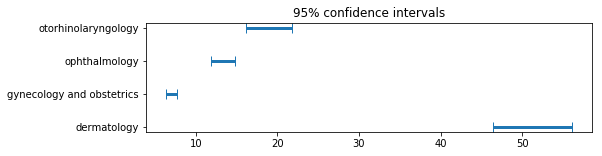

95% c. i. if antioquia = [21.51713205 25.4229203 ]
95% c. i. if valle del cauca = [13.07560024 16.50183073]


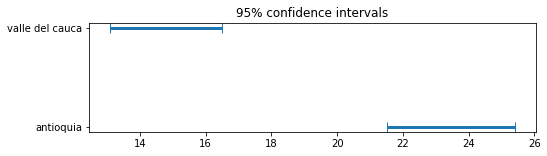

95% c. i. if 2008 = [13.52718872 17.77242218]
95% c. i. if 2009 = [15.83987154 20.91699605]
95% c. i. if 2010 = [17.52077535 23.81515905]
95% c. i. if 2011 = [19.33460803 26.19698853]
95% c. i. if 2012 = [22.00197628 30.24733202]


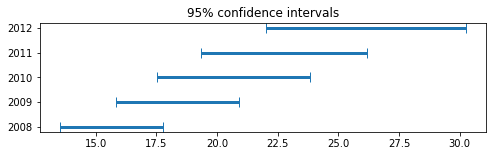

In [12]:
np.random.seed(10)
print('Mean of number of surgeries:\n')

lst = []
for i in np.unique(subpanel['spec_en']):
    data = subpanel['n_surgeries'][subpanel['spec_en']==i]
    ci_mean = bs_95_ci(data, np.mean, size=10000)
    lst.append([i, ci_mean[0], ci_mean[1]])
    print('95% c. i. if',i,'=',ci_mean)
df = pd.DataFrame(lst)
df.columns = ['spec_en','ci_min','ci_max']
df['ci_mid'] = (df['ci_min'] + df['ci_max'])/2
df['half_size'] = df['ci_mid'] - df['ci_min']
plt.figure(figsize=(8,2))
_ = plt.errorbar(df['ci_mid'], df['spec_en'], xerr=df['half_size'],
                 ls='', elinewidth=3, capsize=5)
plt.title('95% confidence intervals')
plt.show()

lst = []
for i in np.unique(subpanel['department']):
    data = subpanel['n_surgeries'][subpanel['department']==i]
    ci_mean = bs_95_ci(data, np.mean, size=10000)
    lst.append([i, ci_mean[0], ci_mean[1]])
    print('95% c. i. if',i,'=',ci_mean)
df = pd.DataFrame(lst)
df.columns = ['department','ci_min','ci_max']
df['ci_mid'] = (df['ci_min'] + df['ci_max'])/2
df['half_size'] = df['ci_mid'] - df['ci_min']
plt.figure(figsize=(8,2))
_ = plt.errorbar(df['ci_mid'], df['department'], xerr=df['half_size'],
                 ls='', elinewidth=3, capsize=5)
plt.title('95% confidence intervals')
plt.show()

lst = []
for i in np.unique(subpanel['year']):
    data = subpanel['n_surgeries'][subpanel['year']==i]
    ci_mean = bs_95_ci(data, np.mean, size=10000)
    lst.append([i, ci_mean[0], ci_mean[1]])
    print('95% c. i. if',i,'=',ci_mean)
df = pd.DataFrame(lst)
df.columns = ['year','ci_min','ci_max']
df['ci_mid'] = (df['ci_min'] + df['ci_max'])/2
df['half_size'] = df['ci_mid'] - df['ci_min']
plt.figure(figsize=(8,2))
_ = plt.errorbar(df['ci_mid'], df['year'], xerr=df['half_size'],
                 ls='', elinewidth=3, capsize=5)
plt.title('95% confidence intervals')
plt.show()

Mean of number of visits:

95% c. i. if dermatology = [285.06447124 333.0744898 ]
95% c. i. if gynecology and obstetrics = [175.03773907 203.88951503]
95% c. i. if ophthalmology = [156.33012402 187.62800261]
95% c. i. if otorhinolaryngology = [146.40951456 182.9742233 ]


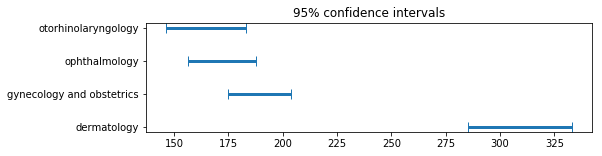

95% c. i. if antioquia = [224.6022833  249.26179465]
95% c. i. if valle del cauca = [126.75030012 147.14447779]


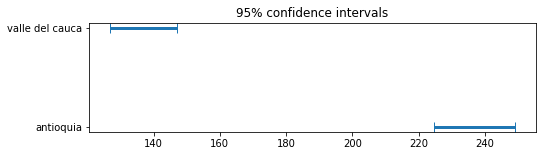

95% c. i. if 2008 = [152.73122568 184.84654669]
95% c. i. if 2009 = [172.87336957 210.81462451]
95% c. i. if 2010 = [187.91237575 229.36053678]
95% c. i. if 2011 = [193.61338432 236.81075526]
95% c. i. if 2012 = [214.73305336 262.86086957]


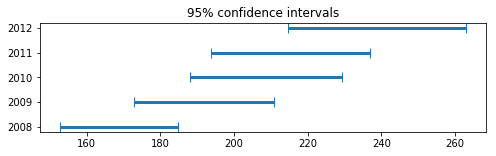

In [13]:
np.random.seed(10)
print('Mean of number of visits:\n')

lst = []
for i in np.unique(subpanel['spec_en']):
    data = subpanel['n_visits'][subpanel['spec_en']==i]
    ci_mean = bs_95_ci(data, np.mean, size=10000)
    lst.append([i, ci_mean[0], ci_mean[1]])
    print('95% c. i. if',i,'=',ci_mean)
df = pd.DataFrame(lst)
df.columns = ['spec_en','ci_min','ci_max']
df['ci_mid'] = (df['ci_min'] + df['ci_max'])/2
df['half_size'] = df['ci_mid'] - df['ci_min']
plt.figure(figsize=(8,2))
_ = plt.errorbar(df['ci_mid'], df['spec_en'], xerr=df['half_size'],
                 ls='', elinewidth=3, capsize=5)
plt.title('95% confidence intervals')
plt.show()

lst = []
for i in np.unique(subpanel['department']):
    data = subpanel['n_visits'][subpanel['department']==i]
    ci_mean = bs_95_ci(data, np.mean, size=10000)
    lst.append([i, ci_mean[0], ci_mean[1]])
    print('95% c. i. if',i,'=',ci_mean)
df = pd.DataFrame(lst)
df.columns = ['department','ci_min','ci_max']
df['ci_mid'] = (df['ci_min'] + df['ci_max'])/2
df['half_size'] = df['ci_mid'] - df['ci_min']
plt.figure(figsize=(8,2))
_ = plt.errorbar(df['ci_mid'], df['department'], xerr=df['half_size'],
                 ls='', elinewidth=3, capsize=5)
plt.title('95% confidence intervals')
plt.show()

lst = []
for i in np.unique(subpanel['year']):
    data = subpanel['n_visits'][subpanel['year']==i]
    ci_mean = bs_95_ci(data, np.mean, size=10000)
    lst.append([i, ci_mean[0], ci_mean[1]])
    print('95% c. i. if',i,'=',ci_mean)
df = pd.DataFrame(lst)
df.columns = ['year','ci_min','ci_max']
df['ci_mid'] = (df['ci_min'] + df['ci_max'])/2
df['half_size'] = df['ci_mid'] - df['ci_min']
plt.figure(figsize=(8,2))
_ = plt.errorbar(df['ci_mid'], df['year'], xerr=df['half_size'],
                 ls='', elinewidth=3, capsize=5)
plt.title('95% confidence intervals')
plt.show()

Mean of surgeries-to-visits ratio:

95% c. i. if dermatology = [0.18837255 0.21554104]
95% c. i. if gynecology and obstetrics = [0.06123718 0.07769635]
95% c. i. if ophthalmology = [0.09275932 0.1127296 ]
95% c. i. if otorhinolaryngology = [0.12524709 0.15436289]


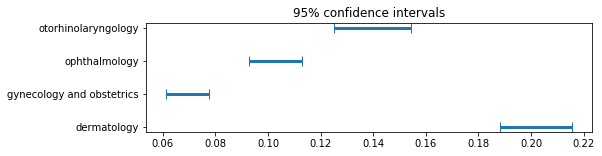

95% c. i. if antioquia = [0.10992058 0.12412075]
95% c. i. if valle del cauca = [0.11999522 0.14085257]


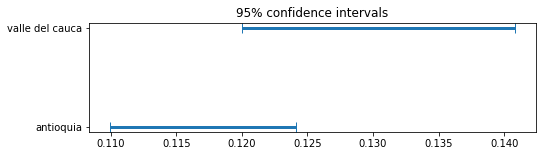

95% c. i. if 2008 = [0.10952586 0.13801082]
95% c. i. if 2009 = [0.10388632 0.12896898]
95% c. i. if 2010 = [0.10641497 0.1334478 ]
95% c. i. if 2011 = [0.11404934 0.14059245]
95% c. i. if 2012 = [0.10815701 0.13319427]


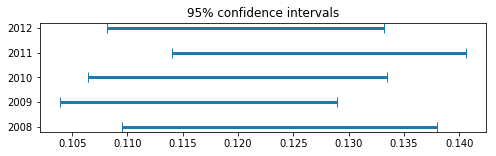

In [14]:
np.random.seed(10)
print('Mean of surgeries-to-visits ratio:\n')

lst = []
for i in np.unique(subpanel['spec_en']):
    data = subpanel['surgeries2visits'][subpanel['spec_en']==i]
    ci_mean = bs_95_ci(data, np.mean, size=10000)
    lst.append([i, ci_mean[0], ci_mean[1]])
    print('95% c. i. if',i,'=',ci_mean)
df = pd.DataFrame(lst)
df.columns = ['spec_en','ci_min','ci_max']
df['ci_mid'] = (df['ci_min'] + df['ci_max'])/2
df['half_size'] = df['ci_mid'] - df['ci_min']
plt.figure(figsize=(8,2))
_ = plt.errorbar(df['ci_mid'], df['spec_en'], xerr=df['half_size'],
                 ls='', elinewidth=3, capsize=5)
plt.title('95% confidence intervals')
plt.show()

lst = []
for i in np.unique(subpanel['department']):
    data = subpanel['surgeries2visits'][subpanel['department']==i]
    ci_mean = bs_95_ci(data, np.mean, size=10000)
    lst.append([i, ci_mean[0], ci_mean[1]])
    print('95% c. i. if',i,'=',ci_mean)
df = pd.DataFrame(lst)
df.columns = ['department','ci_min','ci_max']
df['ci_mid'] = (df['ci_min'] + df['ci_max'])/2
df['half_size'] = df['ci_mid'] - df['ci_min']
plt.figure(figsize=(8,2))
_ = plt.errorbar(df['ci_mid'], df['department'], xerr=df['half_size'],
                 ls='', elinewidth=3, capsize=5)
plt.title('95% confidence intervals')
plt.show()

lst = []
for i in np.unique(subpanel['year']):
    data = subpanel['surgeries2visits'][subpanel['year']==i]
    ci_mean = bs_95_ci(data, np.mean, size=10000)
    lst.append([i, ci_mean[0], ci_mean[1]])
    print('95% c. i. if',i,'=',ci_mean)
df = pd.DataFrame(lst)
df.columns = ['year','ci_min','ci_max']
df['ci_mid'] = (df['ci_min'] + df['ci_max'])/2
df['half_size'] = df['ci_mid'] - df['ci_min']
plt.figure(figsize=(8,2))
_ = plt.errorbar(df['ci_mid'], df['year'], xerr=df['half_size'],
                 ls='', elinewidth=3, capsize=5)
plt.title('95% confidence intervals')
plt.show()

Conclusions:

Specialty definetly changes the mean of surgeries, not necessarialy the mean of visits. It definetly changes the mean of surgeries-to-visits ratio. 

Department definetly changes the mean of surgeries and the mean of visits. It doesn't necessarialy change the mean of surgeries-to-visits ratio (the department with more visits also has more surgeries). 

Year definetly changes the mean of surgeries and the mean of visits in the long run, if you compare 2008 to 2012 for example. As time pass, both measurements tend to increase. However, because of that, year does not change the the mean of surgeries-to-visits ratio.

Now I want to see how specialty, department and year affects the relationship between number of surgeries and number of visits.

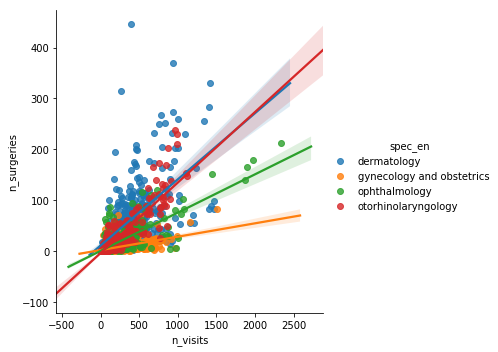

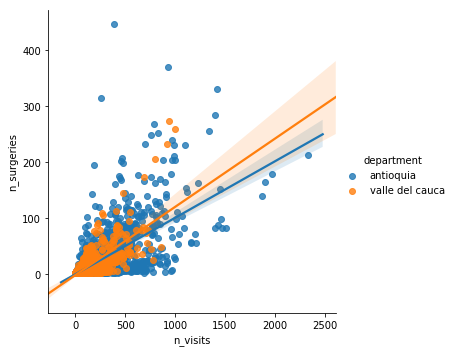

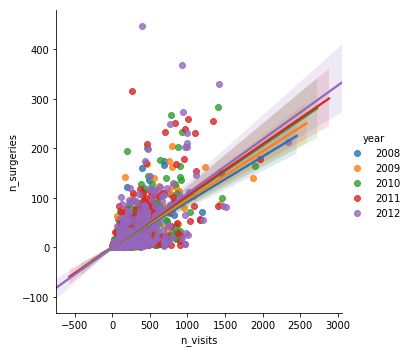

In [15]:
fig_0 = sns.lmplot(x='n_visits',y='n_surgeries',
               hue='spec_en',data=subpanel)
fig_1 = sns.lmplot(x='n_visits',y='n_surgeries',
               hue='department',data=subpanel)
fig_2 = sns.lmplot(x='n_visits',y='n_surgeries',
               hue='year',data=subpanel)
plt.show()

Let's use confidence intervals to test the slope and the intercept of the above regressions.

In [16]:
def draw_bs_pairs_linreg(x, y, size=1):
    inds = np.arange(len(x))
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)
    return bs_slope_reps, bs_intercept_reps

def bs_95_ci_linreg(x, y, size=1):
    slope_reps, intercept_reps = draw_bs_pairs_linreg(x, y, size)
    slope_ci = np.percentile(slope_reps, [2.5, 97.5])
    intercept_ci = np.percentile(intercept_reps, [2.5, 97.5])
    return slope_ci, intercept_ci

Linear regression of surgeries against visits:

95% c.i. for   slope   if dermatology = [0.10920227 0.15221808]
95% c.i. for intercept if dermatology = [ 5.51690292 15.93671371]
95% c.i. for   slope   if gynecology and obstetrics = [0.02148381 0.03145862]
95% c.i. for intercept if gynecology and obstetrics = [1.14923261 2.79087322]
95% c.i. for   slope   if ophthalmology = [0.06525852 0.08292921]
95% c.i. for intercept if ophthalmology = [-0.70281578  1.75278064]
95% c.i. for   slope   if otorhinolaryngology = [0.11955877 0.15563982]
95% c.i. for intercept if otorhinolaryngology = [-5.69772908 -1.77957903]


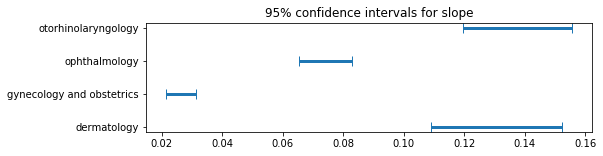

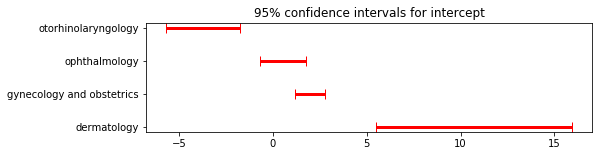

95% c.i. for   slope   if antioquia = [0.09071484 0.11196286]
95% c.i. for intercept if antioquia = [-2.26326857  1.21324669]
95% c.i. for   slope   if valle del cauca = [0.0962974  0.14618018]
95% c.i. for intercept if valle del cauca = [-4.60837462  0.69109502]


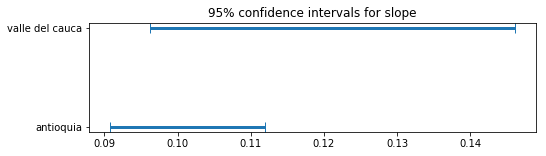

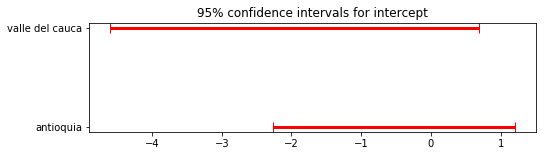

95% c.i. for   slope   if 2008 = [0.07595117 0.10786473]
95% c.i. for intercept if 2008 = [-1.58987214  1.87141876]
95% c.i. for   slope   if 2009 = [0.08184215 0.11351076]
95% c.i. for intercept if 2009 = [-2.45529819  1.63979454]
95% c.i. for   slope   if 2010 = [0.08374092 0.12620315]
95% c.i. for intercept if 2010 = [-4.30766077  1.9547798 ]
95% c.i. for   slope   if 2011 = [0.08489368 0.12699341]
95% c.i. for intercept if 2011 = [-3.06120103  3.1607159 ]
95% c.i. for   slope   if 2012 = [0.08796916 0.13306351]
95% c.i. for intercept if 2012 = [-3.99092919  3.31246053]


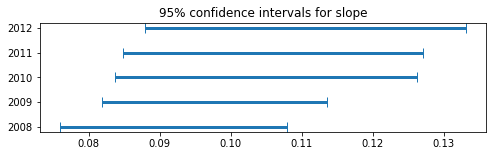

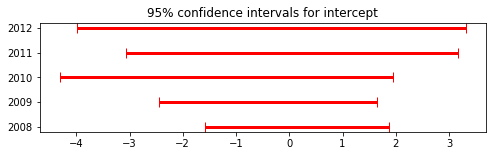

In [17]:
np.random.seed(10)
print('Linear regression of surgeries against visits:\n')

# Code for 95% c.i. for slope and intercept if specialty.
lst_slope = []
lst_intercept = []
for i in np.unique(subpanel['spec_en']):
    x = np.array(subpanel['n_visits'][subpanel['spec_en']==i])
    y = np.array(subpanel['n_surgeries'][subpanel['spec_en']==i])
    ci_slope, ci_intercept = bs_95_ci_linreg(x, y, size=1000)
    lst_slope.append([i, ci_slope[0], ci_slope[1]])
    lst_intercept.append([i, ci_intercept[0], ci_intercept[1]])
    print('95% c.i. for   slope   if',i,'=',ci_slope)
    print('95% c.i. for intercept if',i,'=',ci_intercept)
    
df_slope  = pd.DataFrame(lst_slope)
df_slope.columns = ['spec_en','ci_min','ci_max']
df_slope['ci_mid'] = (df_slope['ci_min'] + df_slope['ci_max'])/2
df_slope['half_size'] = df_slope['ci_mid'] - df_slope['ci_min']
plt.figure(figsize=(8,2))
_ = plt.errorbar(df_slope['ci_mid'], df_slope['spec_en'],
                 xerr=df_slope['half_size'],
                 ls='', elinewidth=3, capsize=5)
plt.title('95% confidence intervals for slope')

df_intercept = pd.DataFrame(lst_intercept)
df_intercept.columns = ['spec_en','ci_min','ci_max']
df_intercept['ci_mid'] = (df_intercept['ci_min'] + df_intercept['ci_max'])/2
df_intercept['half_size'] = df_intercept['ci_mid'] - df_intercept['ci_min']
plt.figure(figsize=(8,2))
_ = plt.errorbar(df_intercept['ci_mid'], df_intercept['spec_en'],
                 xerr=df_intercept['half_size'],
                 ls='', elinewidth=3, capsize=5, ecolor='red')
plt.title('95% confidence intervals for intercept')
plt.show()

# Code for 95% c.i. for slope and intercept if department.
lst_slope = []
lst_intercept = []
for i in np.unique(subpanel['department']):
    x = np.array(subpanel['n_visits'][subpanel['department']==i])
    y = np.array(subpanel['n_surgeries'][subpanel['department']==i])
    ci_slope, ci_intercept = bs_95_ci_linreg(x, y, size=1000)
    lst_slope.append([i, ci_slope[0], ci_slope[1]])
    lst_intercept.append([i, ci_intercept[0], ci_intercept[1]])
    print('95% c.i. for   slope   if',i,'=',ci_slope)
    print('95% c.i. for intercept if',i,'=',ci_intercept)
    
df_slope  = pd.DataFrame(lst_slope)
df_slope.columns = ['department','ci_min','ci_max']
df_slope['ci_mid'] = (df_slope['ci_min'] + df_slope['ci_max'])/2
df_slope['half_size'] = df_slope['ci_mid'] - df_slope['ci_min']
plt.figure(figsize=(8,2))
_ = plt.errorbar(df_slope['ci_mid'], df_slope['department'],
                 xerr=df_slope['half_size'],
                 ls='', elinewidth=3, capsize=5)
plt.title('95% confidence intervals for slope')

df_intercept = pd.DataFrame(lst_intercept)
df_intercept.columns = ['department','ci_min','ci_max']
df_intercept['ci_mid'] = (df_intercept['ci_min'] + df_intercept['ci_max'])/2
df_intercept['half_size'] = df_intercept['ci_mid'] - df_intercept['ci_min']
plt.figure(figsize=(8,2))
_ = plt.errorbar(df_intercept['ci_mid'], df_intercept['department'],
                 xerr=df_intercept['half_size'],
                 ls='', elinewidth=3, capsize=5, ecolor='red')
plt.title('95% confidence intervals for intercept')
plt.show()

# Code for 95% c.i. for slope and intercept if year.
lst_slope = []
lst_intercept = []
for i in np.unique(subpanel['year']):
    x = np.array(subpanel['n_visits'][subpanel['year']==i])
    y = np.array(subpanel['n_surgeries'][subpanel['year']==i])
    ci_slope, ci_intercept = bs_95_ci_linreg(x, y, size=1000)
    lst_slope.append([i, ci_slope[0], ci_slope[1]])
    lst_intercept.append([i, ci_intercept[0], ci_intercept[1]])
    print('95% c.i. for   slope   if',i,'=',ci_slope)
    print('95% c.i. for intercept if',i,'=',ci_intercept)
    
df_slope  = pd.DataFrame(lst_slope)
df_slope.columns = ['year','ci_min','ci_max']
df_slope['ci_mid'] = (df_slope['ci_min'] + df_slope['ci_max'])/2
df_slope['half_size'] = df_slope['ci_mid'] - df_slope['ci_min']
plt.figure(figsize=(8,2))
_ = plt.errorbar(df_slope['ci_mid'], df_slope['year'],
                 xerr=df_slope['half_size'],
                 ls='', elinewidth=3, capsize=5)
plt.title('95% confidence intervals for slope')

df_intercept = pd.DataFrame(lst_intercept)
df_intercept.columns = ['year','ci_min','ci_max']
df_intercept['ci_mid'] = (df_intercept['ci_min'] + df_intercept['ci_max'])/2
df_intercept['half_size'] = df_intercept['ci_mid'] - df_intercept['ci_min']
plt.figure(figsize=(8,2))
_ = plt.errorbar(df_intercept['ci_mid'], df_intercept['year'],
                 xerr=df_intercept['half_size'],
                 ls='', elinewidth=3, capsize=5, ecolor='red')
plt.title('95% confidence intervals for intercept')
plt.show()

Conclusions:
    
Dermatology and otorhinolaryngology may have the same slope, but not the same intercept. gynecology & obstetrics and ophthalmology may have the same intercept, but not the same slope.

Departments may have the same slope and intercept. There is more uncertainty regarding Valle del Cauca than Antioquia.

Year may have the same slope and intercept, although slope may be increasing with year. Uncertainty seems to increase with year. 